Предсказание времени поездки такси Нью-Йорка/
## Подготовка

In [ ]:
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.figure(figsize=(6, 8))

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси.

In [2]:
df = pd.read_csv("train.csv")

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [3]:
df = df.drop(columns='dropoff_datetime')


In [4]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 111.3+ MB


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке:

In [5]:
df.trip_duration

0           455
1           663
2          2124
3           429
4           435
           ... 
1458639     778
1458640     655
1458641     764
1458642     373
1458643     198
Name: trip_duration, Length: 1458644, dtype: int64

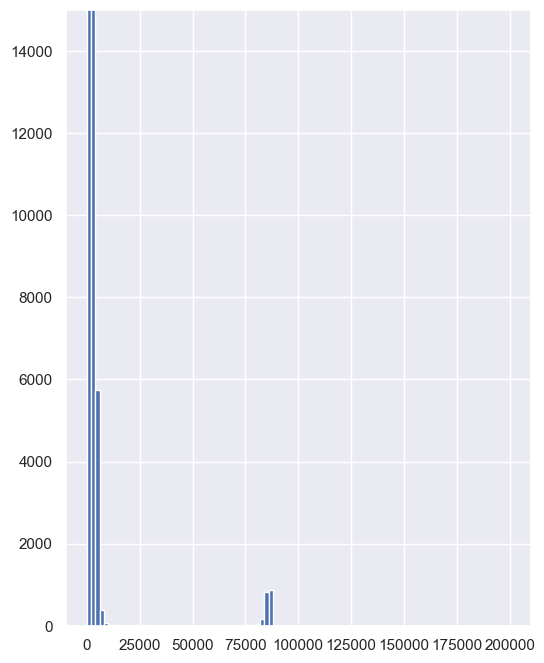

In [6]:
plt.figure(figsize=(6, 8))
plt.hist(df.trip_duration, bins=100, range=[0, 200000])
plt.ylim(0, 15000)
plt.show()


В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$


Будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.


In [7]:

df['log_trip_duration'] = df['trip_duration'].apply(np.log1p)
trip_duration_srs = df['trip_duration']
df = df.drop(['trip_duration'], axis=1)

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [8]:
def RMSE(y_actual_arr, y_predict_arr):
    return np.sqrt(np.square(np.subtract(y_actual_arr, y_predict_arr)).mean())


print("Mean constant predict score:", RMSE(df['log_trip_duration'], df.log_trip_duration.mean()))

Mean constant predict score: 0.7957592365411509


## Изучаем `pickup_datetime`

Для начала давайте посмотрим, сколько всего было поездок в каждый из дней:

<Axes: xlabel='pickup_datetime', ylabel='count'>

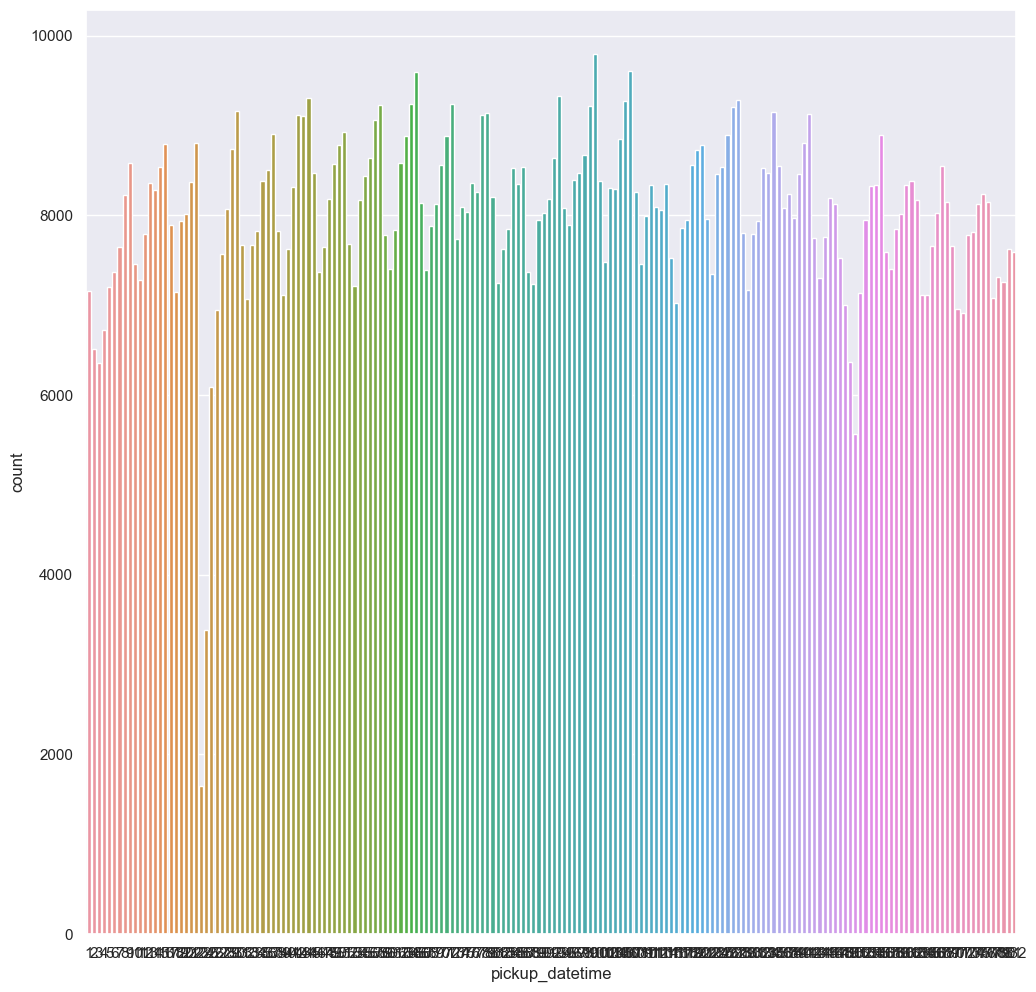

In [9]:
sns.set(rc={"figure.figsize": (12, 12)})
sns.countplot(x=df["pickup_datetime"].dt.dayofyear)


In [10]:
df["pickup_datetime"].dt.dayofyear.value_counts().nsmallest(20, keep='all')

23     1648
24     3383
151    5570
25     6084
3      6353
150    6372
2      6512
4      6725
172    6910
26     6941
171    6962
149    7004
116    7028
32     7064
178    7084
39     7110
164    7112
165    7114
152    7131
18     7146
Name: pickup_datetime, dtype: int64

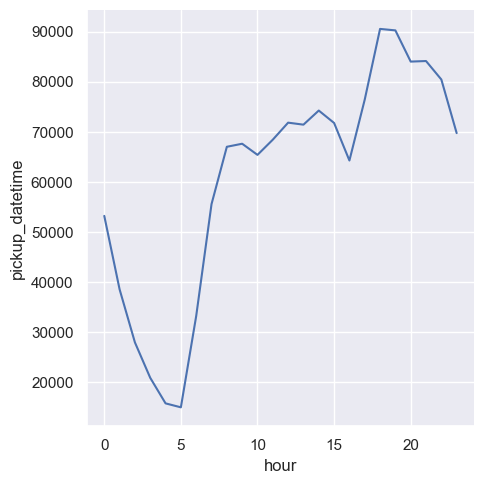

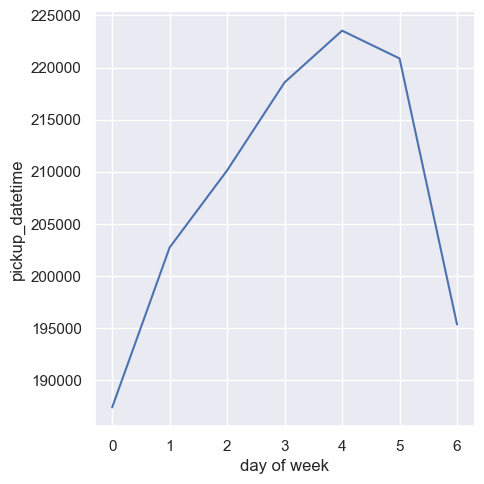

In [11]:
print(sns.relplot(data=df["pickup_datetime"].dt.hour.value_counts(), kind='line').set(xlabel="hour"))
print(sns.relplot(data=df["pickup_datetime"].dt.dayofweek.value_counts(), kind='line').set(xlabel="day of week"))


Нарисуем на одном графике зависимости количества поездок от часа в сутках для разных месяцев. Аналогично нарисуем зависимости количества поездок от часа в сутках для разных дней недели.

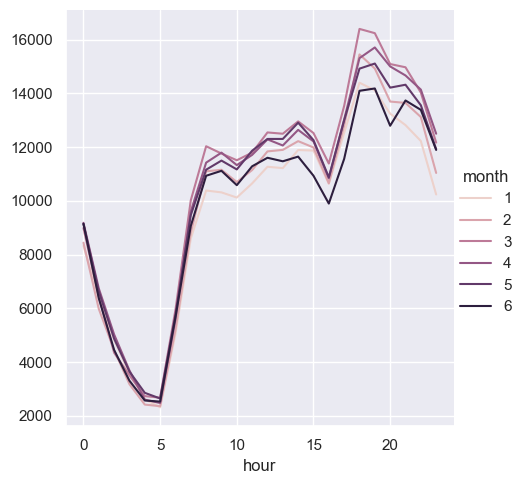

In [12]:
df["hour"] = df.pickup_datetime.dt.hour
df["month"] = df.pickup_datetime.dt.month
df["day_of_week"] = df.pickup_datetime.dt.dayofweek
df["day_of_year"] = df.pickup_datetime.dt.dayofyear

sns.relplot(data=df.groupby(["month", "hour"]).size().to_frame(), x="hour", y=0, hue="month", kind='line')

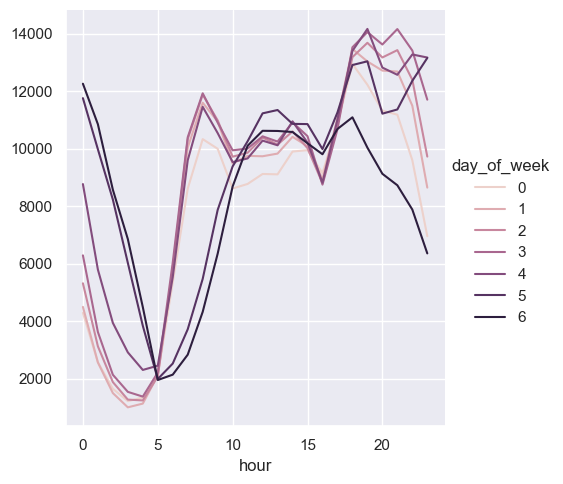

In [13]:
sns.relplot(data=df.groupby(["day_of_week", "hour"]).size().to_frame(), x="hour", y=0, hue="day_of_week", kind='line')


**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

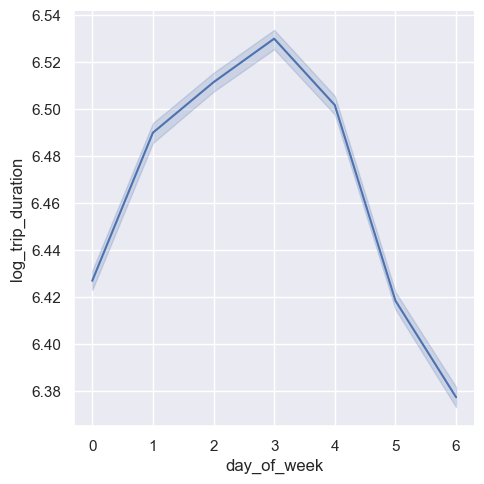

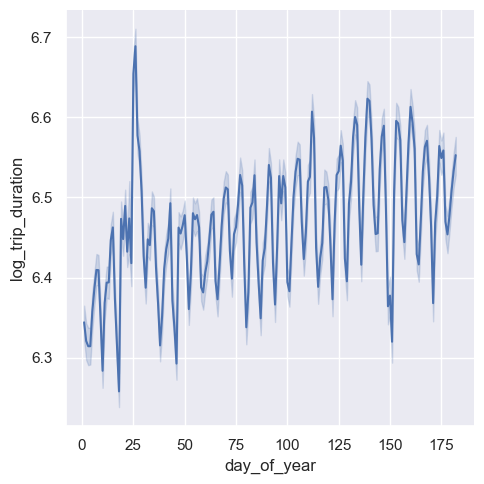

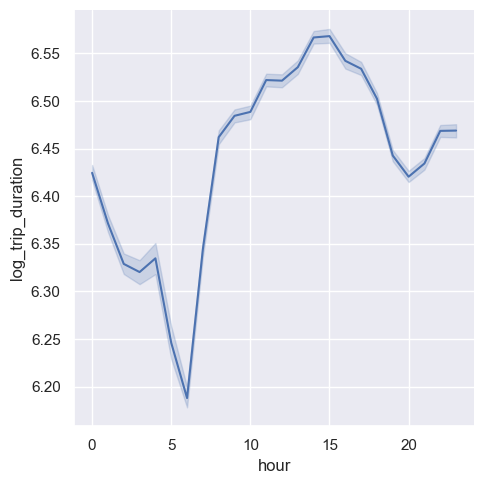

In [14]:
df_train, df_test = np.split(df, [int(.7 * len(df))])

print(sns.relplot(x=df_train["day_of_week"], y=df_train["log_trip_duration"], kind='line'))
print(sns.relplot(x=df_train["day_of_year"], y=df_train["log_trip_duration"], kind='line'))
print(sns.relplot(x=df_train["hour"], y=df_train["log_trip_duration"], kind='line'))

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [60]:
def make_time_features(df_with_pickup_datetime):
    df_with_pickup_datetime["hour"] = df_with_pickup_datetime["pickup_datetime"].dt.hour
    df_with_pickup_datetime["month"] = df_with_pickup_datetime["pickup_datetime"].dt.month
    df_with_pickup_datetime["day_of_week"] = df_with_pickup_datetime["pickup_datetime"].dt.dayofweek
    df_with_pickup_datetime["day_of_year"] = df_with_pickup_datetime["pickup_datetime"].dt.dayofyear
    return df_with_pickup_datetime


def make_anomaly_features(df_with_pickup_datetime):
    df_with_pickup_datetime["bigger_anomaly"] = np.where(
        np.logical_and(df_with_pickup_datetime.day_of_year >= 23, df_with_pickup_datetime.day_of_year <= 25), 1, 0)
    df_with_pickup_datetime["smaller_anomaly"] = np.where(
        np.logical_and(df_with_pickup_datetime.day_of_year >= 149, df_with_pickup_datetime.day_of_year <= 152), 1, 0)
    return df_with_pickup_datetime


df_train["bigger_anomaly"] = np.where(np.logical_and(df_train.day_of_year >= 23, df_train.day_of_year <= 25), 1, 0)
df_train["smaller_anomaly"] = np.where(np.logical_and(df_train.day_of_year >= 149, df_train.day_of_year <= 152), 1, 0)
df_test = make_anomaly_features(df_test)
# всё остальное было добавлено выше

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge

features_to_exclude = ['id', 'vendor_id', 'pickup_datetime', 'dropoff_latitude', 'dropoff_longitude', 'pickup_latitude',
                       'pickup_longitude', 'store_and_fwd_flag', 'day_of_year']

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), []),
        ('ohe', OneHotEncoder(), ['day_of_week', 'hour', 'month'])],
    remainder='passthrough',
)

Ridge_model_task_5 = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regression_ridge', Ridge())])

y_train = df_train["log_trip_duration"]
y_test = df_test["log_trip_duration"]
X_train = df_train.drop(columns=features_to_exclude + ['log_trip_duration'])
X_test = df_test.drop(columns=features_to_exclude + ['log_trip_duration'])

Ridge_model_task_5.fit(X_train, y_train)

print("R2 score:", Ridge_model_task_5.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, Ridge_model_task_5.predict(X_test)))

R2 score: 0.01855312047394042
MSE: 0.6217305611189335


In [17]:
del y_train
del y_test
del X_train
del X_test
gc.collect()

7582

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [18]:
import folium


def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [19]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [20]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

In [21]:
import gc

gc.collect()



3462

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [22]:

def haversine(lat1, lng1, lat2, lng2):
    r = 6371
    phi1, lam1, phi2, lam2 = map(np.radians, (lat1, lng1, lat2, lng2))
    first_part = np.sin((phi2 - phi1) / 2) ** 2
    second_part = np.cos(phi1) * np.cos(phi2) * np.sin((lam2 - lam1) / 2) ** 2
    return 2 * r * np.arcsin(np.sqrt(first_part + second_part))


def make_log_haversine_feature(dff):
    distances = haversine(dff.pickup_latitude, dff.pickup_longitude, dff.dropoff_latitude, dff.dropoff_longitude)
    distances[distances == 0] = distances.mean() # заменяем нулевые расстояния на NaN
    dff['log_haversine'] = np.log(distances)
    return dff

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [23]:
df_train = make_log_haversine_feature(df_train)

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

<Axes: >

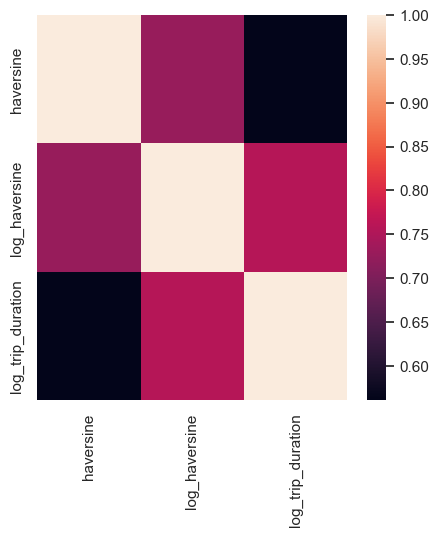

In [24]:
sns.set(rc={'figure.figsize': (5, 5)})
df_train['haversine'] = haversine(df_train.pickup_latitude, df_train.pickup_longitude, df_train.dropoff_latitude,
                                  df_train.dropoff_longitude)
corr_mtrx = df_train[["haversine", "log_haversine", "log_trip_duration"]].corr()
sns.heatmap(data=corr_mtrx, xticklabels=corr_mtrx.columns, yticklabels=corr_mtrx.columns)

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

<Axes: >

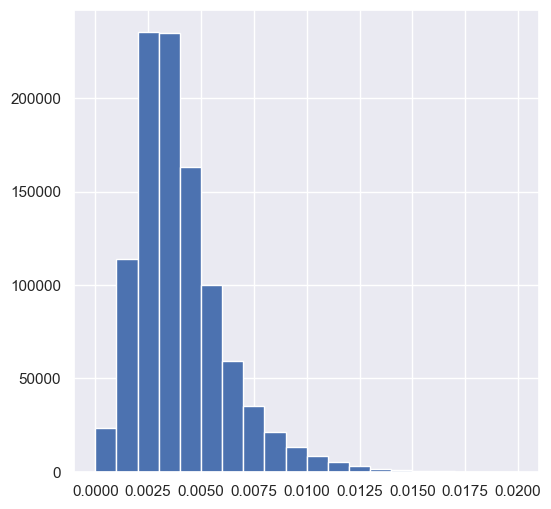

In [25]:
plt.figure(figsize=(6, 6))

df_train['mid_speed'] = df_train.haversine / trip_duration_srs
df_train['mid_speed'].hist(bins=20, range=[0, 0.02])

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

<Axes: >

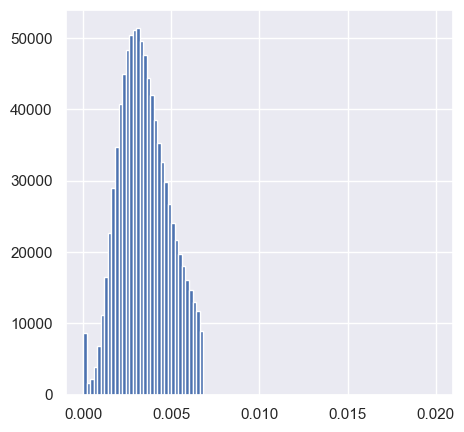

In [26]:

df_train.loc[df_train['mid_speed'] < np.percentile(df_train["mid_speed"], 90)]['mid_speed'].hist(bins=100,
                                                                                                 range=[0, 0.02])


Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

<Axes: xlabel='hour', ylabel='day_of_week'>

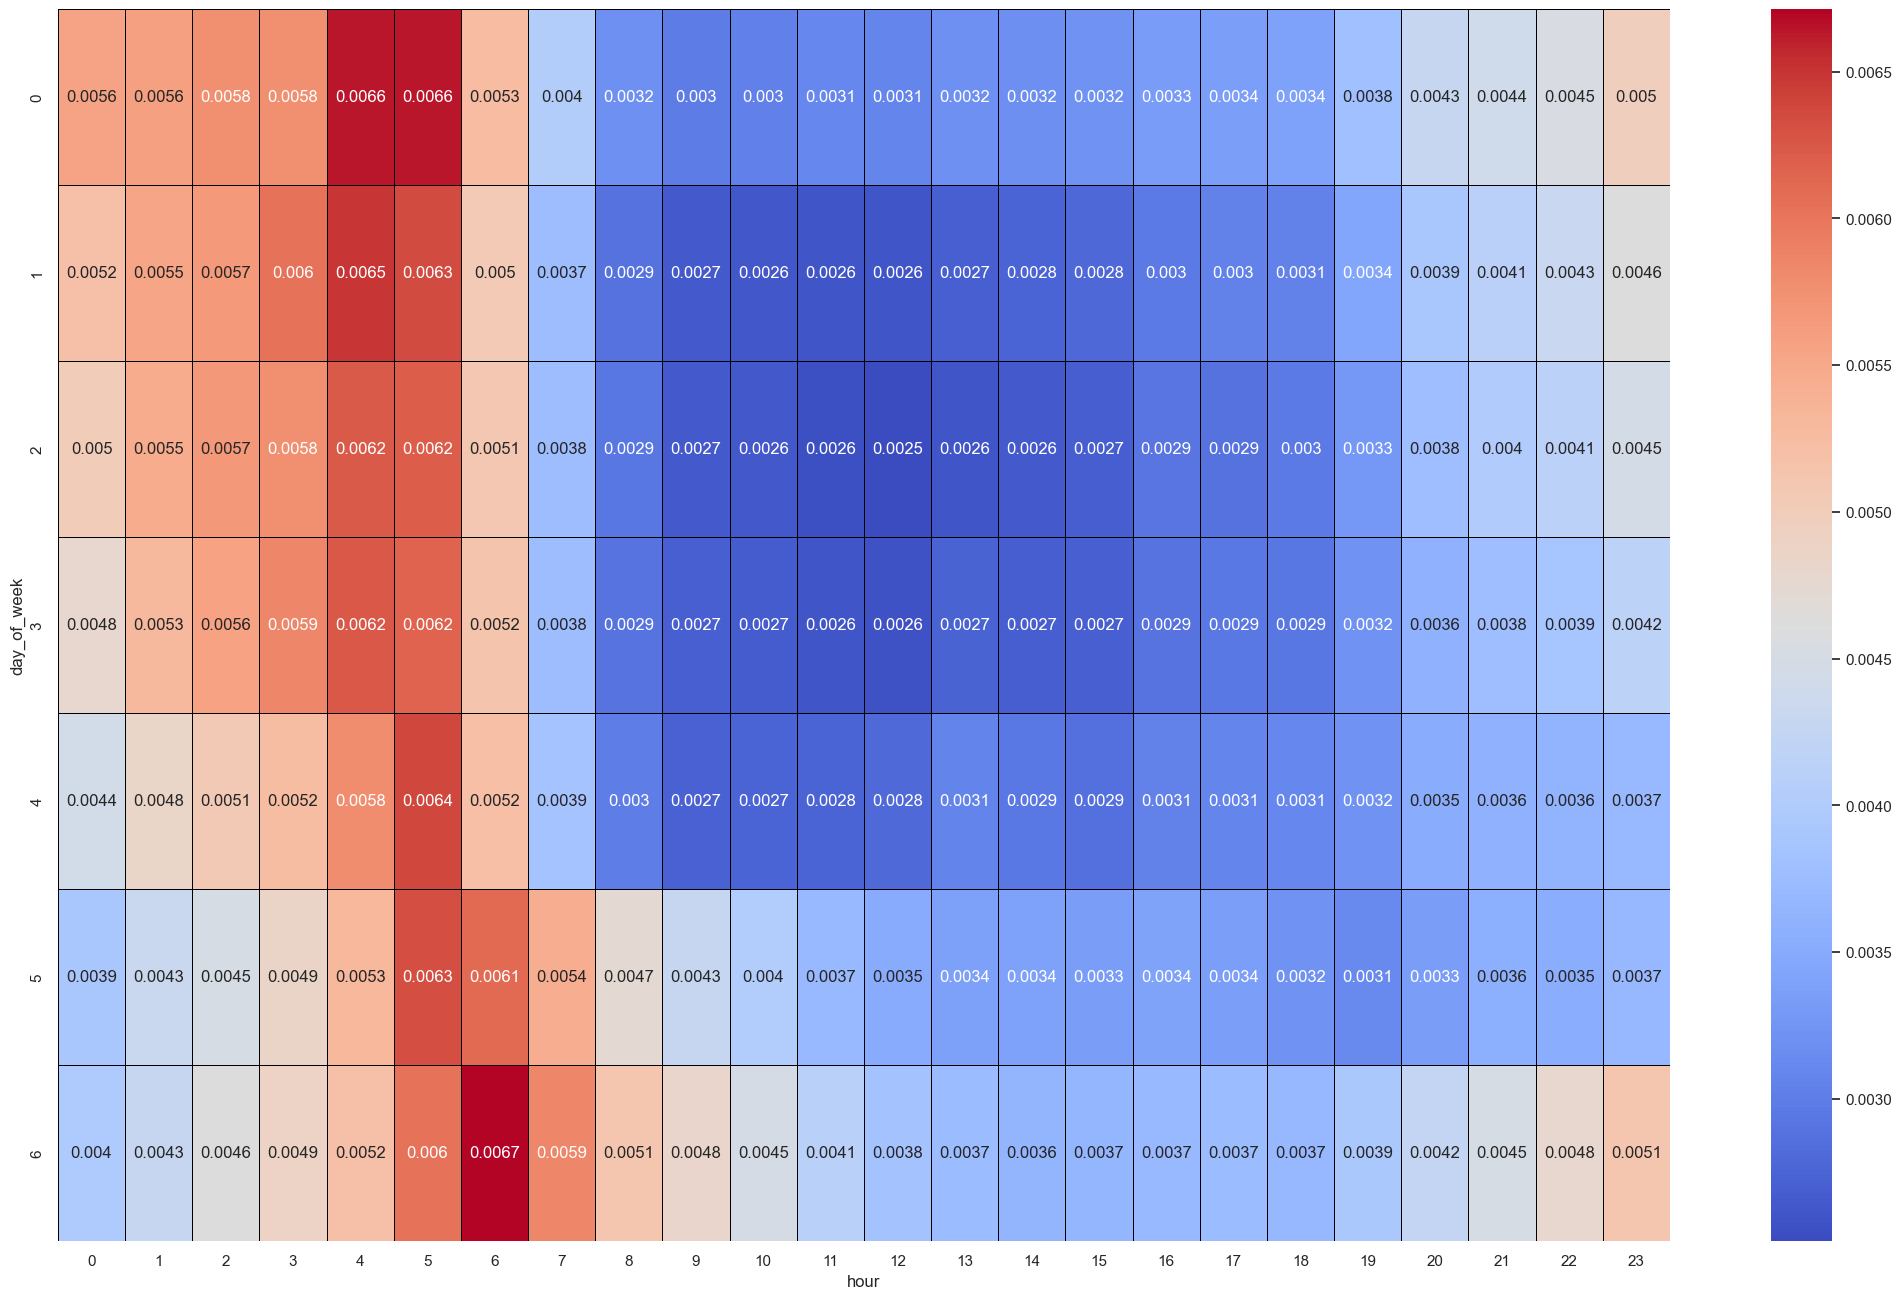

In [27]:
df_train["hour"] = df_train.pickup_datetime.dt.hour
df_train["day_of_week"] = df_train.pickup_datetime.dt.dayofweek
sns.set(rc={'figure.figsize': (26, 16)})

sns.heatmap(df_train.groupby(['day_of_week', 'hour'])['mid_speed'].median().unstack(), annot=True, linewidths=.5,
            linecolor='black', cmap='coolwarm')



Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [28]:

def make_traffic_features(df_with_time_date):
    df_with_time_date["hour"] = df_with_time_date.pickup_datetime.dt.hour
    df_with_time_date["day_of_week"] = df_with_time_date.pickup_datetime.dt.dayofweek

    mask_in_traffic = ((df_with_time_date["day_of_week"].isin([0, 1, 2, 3, 4]) & df_with_time_date["hour"].isin(list(range(7, 23))))
                       | (df_with_time_date["day_of_week"] == 5 & df_with_time_date["hour"].isin(list(range(9, 24))))
                       | (df_with_time_date["day_of_week"] == 6 & df_with_time_date["hour"].isin(list(range(10, 22))))
                       | (df_with_time_date["day_of_week"].isin([5, 6]) & df_with_time_date["hour"].isin(list(range(0, 3))))
                       | (df_with_time_date["day_of_week"].isin([2, 3, 4, 5]) & df_with_time_date["hour"] == 23))

    df_with_time_date['in_traffic'] = 0
    df_with_time_date.loc[mask_in_traffic, "in_traffic"] = 1


    return df_with_time_date


df_train = make_traffic_features(df_train)


df_train.drop(labels=['mid_speed'], axis=1, inplace=True)


**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [29]:
def make_airport_features(df_with_coords):
    #Newark airport
    df_with_coords['newark_start'] = 0
    df_with_coords.loc[(df_with_coords['pickup_latitude'].between(40.71, 40.74)) & (
        df_with_coords['pickup_longitude'].between(-74.2, -74.1)), 'newark_start'] = 1
    df_with_coords['newark_end'] = 0
    df_with_coords.loc[(df_with_coords['dropoff_latitude'].between(40.71, 40.74)) & (
        df_with_coords['dropoff_longitude'].between(-74.2, -74.1)), 'newark_end'] = 1
    #JFK airport
    df_with_coords['jfk_start'] = 0
    df_with_coords.loc[(df_with_coords['pickup_latitude'].between(40.5, 40.7)) & (
        df_with_coords['pickup_longitude'].between(-73.8, -73.7)), 'jfk_start'] = 1
    df_with_coords['jfk_end'] = 0
    df_with_coords.loc[(df_with_coords['dropoff_latitude'].between(40.5, 40.7)) & (
        df_with_coords['dropoff_longitude'].between(-73.8, -73.7)), 'jfk_end'] = 1
    return df_with_coords


df_train = make_airport_features(df_train)


Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

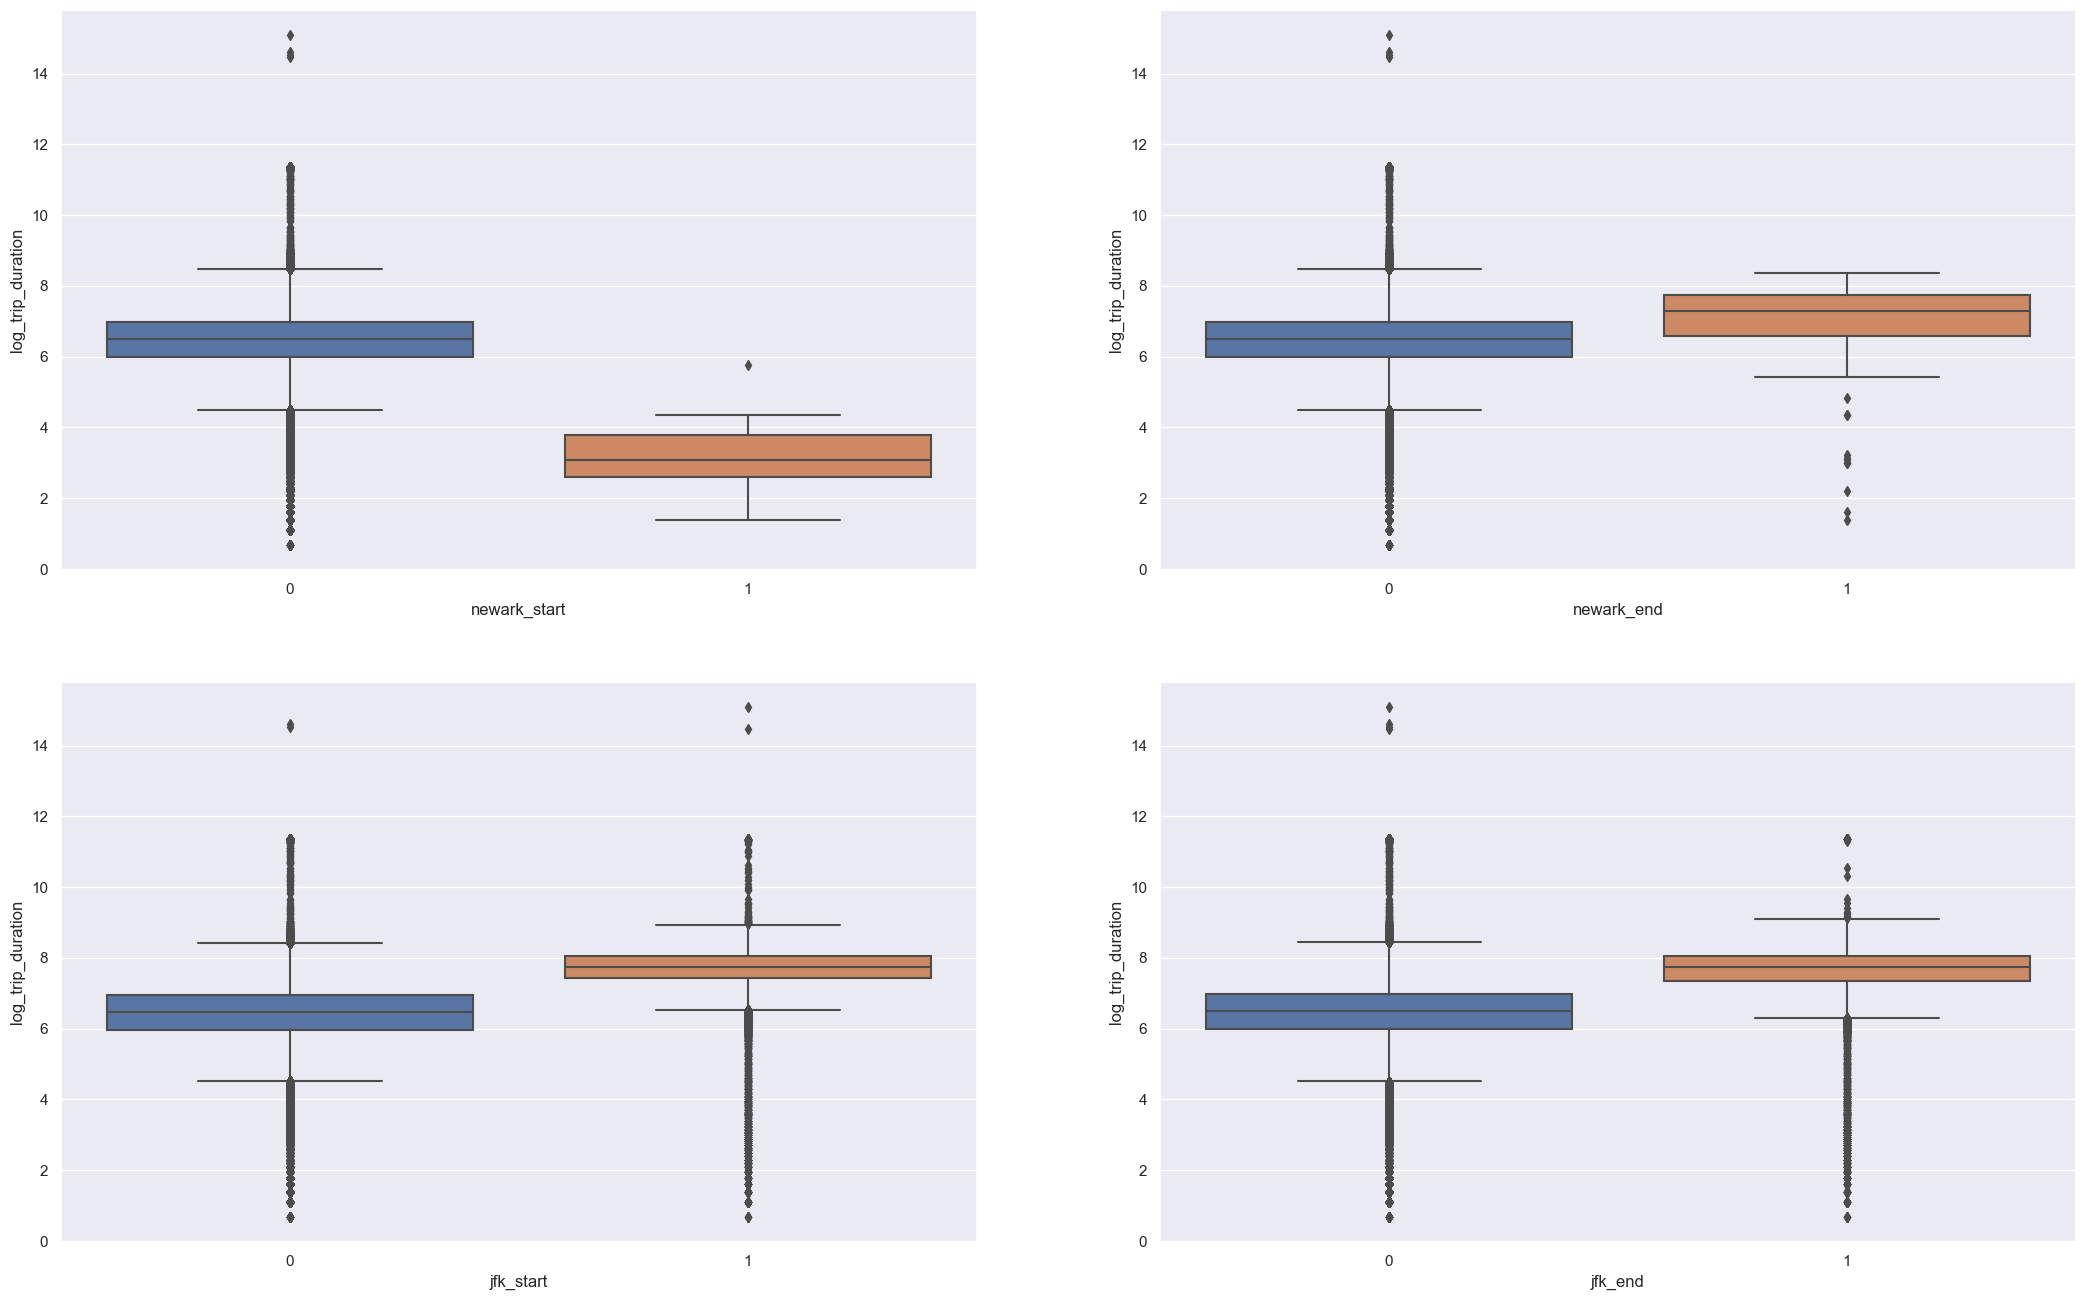

In [30]:
fig, ax = plt.subplots(2, 2)

for i, column in enumerate(['newark_start', 'newark_end', 'jfk_start', 'jfk_end']):
    ax = plt.subplot(2, 2, i + 1)
    sns.boxplot(df_train, x=column, y='log_trip_duration')

    plt.xlabel(column)

plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, left_down_corner, left_upper_corner, right_down_corner, right_upper_corner, columns=3, rows=4):
        self.left_down_corner = left_down_corner
        self.left_upper_corner = left_upper_corner
        self.right_down_corner = right_down_corner
        self.right_upper_corner = right_upper_corner
        self.n_columns = columns
        self.n_rows = rows

        self.columns = np.linspace(left_down_corner[1], right_down_corner[1], num=columns)
        self.rows = np.linspace(left_down_corner[0], left_upper_corner[0], num=rows)
        pass

    def fit(self, X=None, y=None):
        return self

    def transform(self, X):
        X["pickup_column"] = np.searchsorted(self.columns, X["pickup_longitude"])
        X["pickup_row"] = np.searchsorted(self.rows, X["pickup_latitude"])

        X["pickup_cell"] = -1
        X[(X["pickup_row"] != 0) & (X["pickup_row"] != self.n_rows) & (X["pickup_column"] != 0) & (
                X["pickup_column"] != self.n_columns)]["pickup_cell"] = self.n_columns * (X["pickup_column"] - 1) + \
                                                                        X["pickup_row"]

        X["dropoff_column"] = np.searchsorted(self.columns, X["dropoff_longitude"])
        X["dropoff_row"] = np.searchsorted(self.rows, X["dropoff_latitude"])

        X["dropoff_cell"] = -1
        X[(X["dropoff_row"] != 0) & (X["dropoff_row"] != self.n_rows) & (X["dropoff_column"] != 0) & (X[
                                                                                                          "dropoff_column"] != self.n_columns)][
            "dropoff_cell"] = self.n_columns * (X["dropoff_column"] - 1) + \
                              X["dropoff_row"]

        return X.drop(["pickup_column", "pickup_row", "dropoff_column", "dropoff_row"], axis=1)


topLeft = [40.800996, -74.012065]
topRight = [40.784202, -73.946793]
bottomRight = [40.704052, -73.958546]
bottomLeft = [40.710571, -74.020803]
transformer = MapGridTransformer(topLeft, topRight, bottomRight, bottomLeft)
df_train = transformer.transform(df_train)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [32]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021050 entries, 0 to 1021049
Data columns (total 25 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1021050 non-null  object        
 1   vendor_id           1021050 non-null  int64         
 2   pickup_datetime     1021050 non-null  datetime64[ns]
 3   passenger_count     1021050 non-null  int64         
 4   pickup_longitude    1021050 non-null  float64       
 5   pickup_latitude     1021050 non-null  float64       
 6   dropoff_longitude   1021050 non-null  float64       
 7   dropoff_latitude    1021050 non-null  float64       
 8   store_and_fwd_flag  1021050 non-null  object        
 9   log_trip_duration   1021050 non-null  float64       
 10  hour                1021050 non-null  int64         
 11  month               1021050 non-null  int64         
 12  day_of_week         1021050 non-null  int64         
 13  day_of_year 

In [33]:
# препроцессинг для df_test
df_test = make_log_haversine_feature(df_test)
df_test = make_traffic_features(df_test)
df_test = make_airport_features(df_test)
df_test = transformer.transform(df_test)
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021050 entries, 0 to 1021049
Data columns (total 25 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1021050 non-null  object        
 1   vendor_id           1021050 non-null  int64         
 2   pickup_datetime     1021050 non-null  datetime64[ns]
 3   passenger_count     1021050 non-null  int64         
 4   pickup_longitude    1021050 non-null  float64       
 5   pickup_latitude     1021050 non-null  float64       
 6   dropoff_longitude   1021050 non-null  float64       
 7   dropoff_latitude    1021050 non-null  float64       
 8   store_and_fwd_flag  1021050 non-null  object        
 9   log_trip_duration   1021050 non-null  float64       
 10  hour                1021050 non-null  int64         
 11  month               1021050 non-null  int64         
 12  day_of_week         1021050 non-null  int64         
 13  day_of_year 

In [34]:
#удалим haversine, в нём нет необходимости при log_haversine
df_train.drop(columns=['haversine'], axis=1, inplace=True)

In [35]:

# обучение модели
features_to_exclude = ['id', 'vendor_id', 'pickup_datetime', 'dropoff_latitude', 'dropoff_longitude', 'pickup_latitude',
                       'pickup_longitude', 'store_and_fwd_flag', "day_of_year"]

y_train = df_train["log_trip_duration"]
X_train = df_train.drop(columns=features_to_exclude + ["log_trip_duration"])
y_test = df_test["log_trip_duration"]
X_test = df_test.drop(columns=features_to_exclude + ["log_trip_duration"])

preprocessor_task_10 = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['log_haversine']),
        ('ohe', OneHotEncoder(), ['day_of_week', 'hour', 'month', 'pickup_cell', 'dropoff_cell'])],
    remainder='passthrough',
)

Ridge_model_task_10 = Pipeline(steps=[('preprocessor', preprocessor_task_10),
                                      ('regression_ridge', Ridge())])

Ridge_model_task_10.fit(X_train, y_train)

print("R2 score:", Ridge_model_task_10.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, Ridge_model_task_10.predict(X_test)))

R2 score: 0.6168894397014315
MSE: 0.2426942798371733


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [36]:
print('vendor_id:\n', df_train['vendor_id'].value_counts())
print('passenger_count:\n', df_train['passenger_count'].value_counts())
print('store_and_fwd_flag:\n', df_train['store_and_fwd_flag'].value_counts())

vendor_id:
 2    545729
1    475321
Name: vendor_id, dtype: int64
passenger_count:
 1    723569
2    147130
5     54834
3     41897
6     33765
4     19813
0        37
7         3
9         1
8         1
Name: passenger_count, dtype: int64
store_and_fwd_flag:
 N    1015395
Y       5655
Name: store_and_fwd_flag, dtype: int64


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

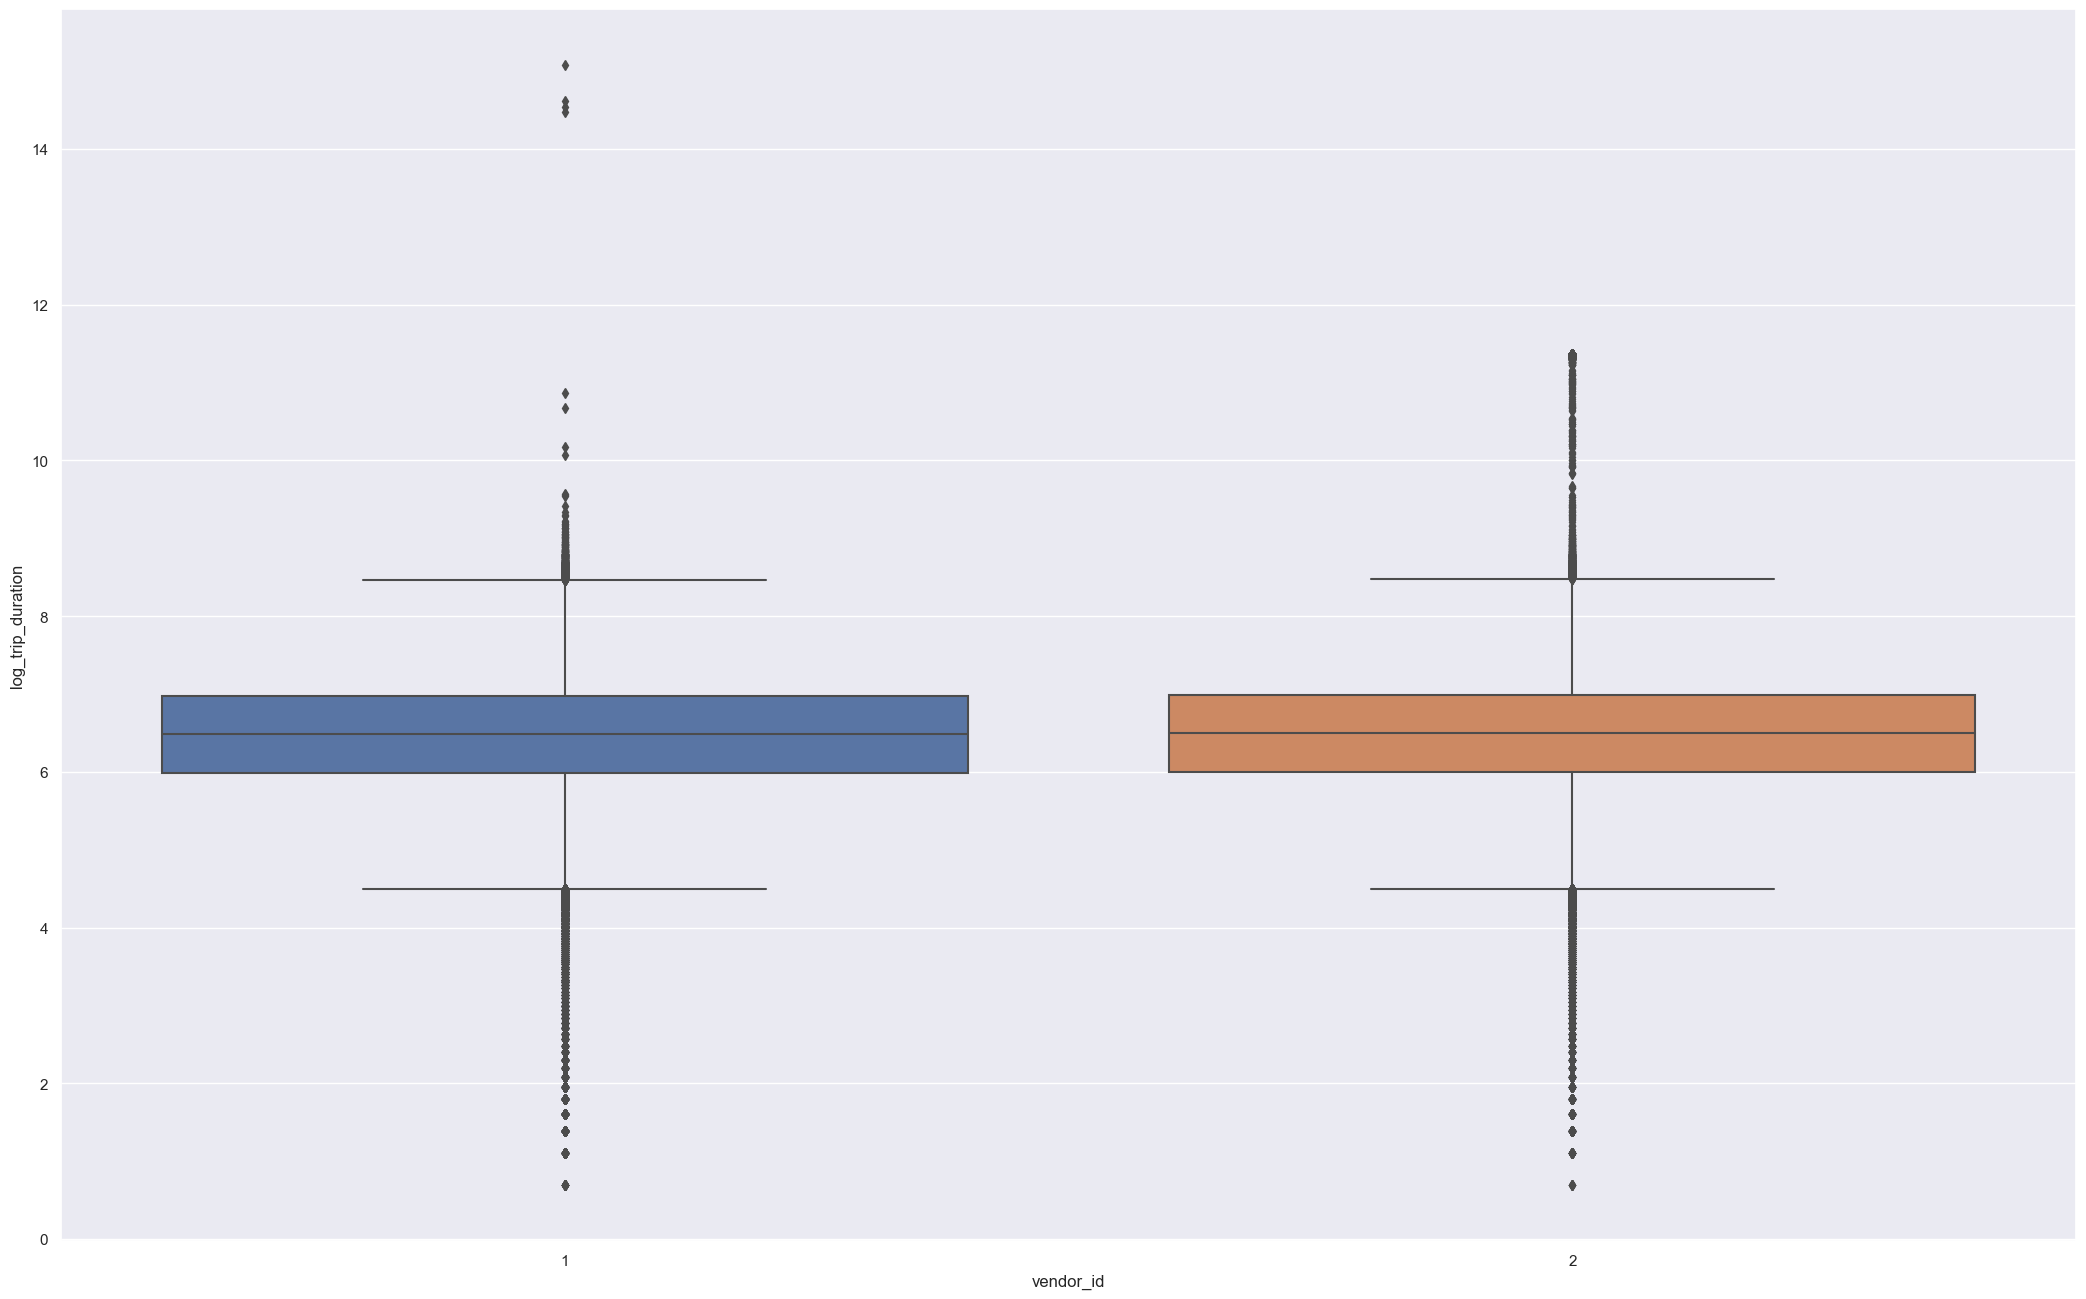

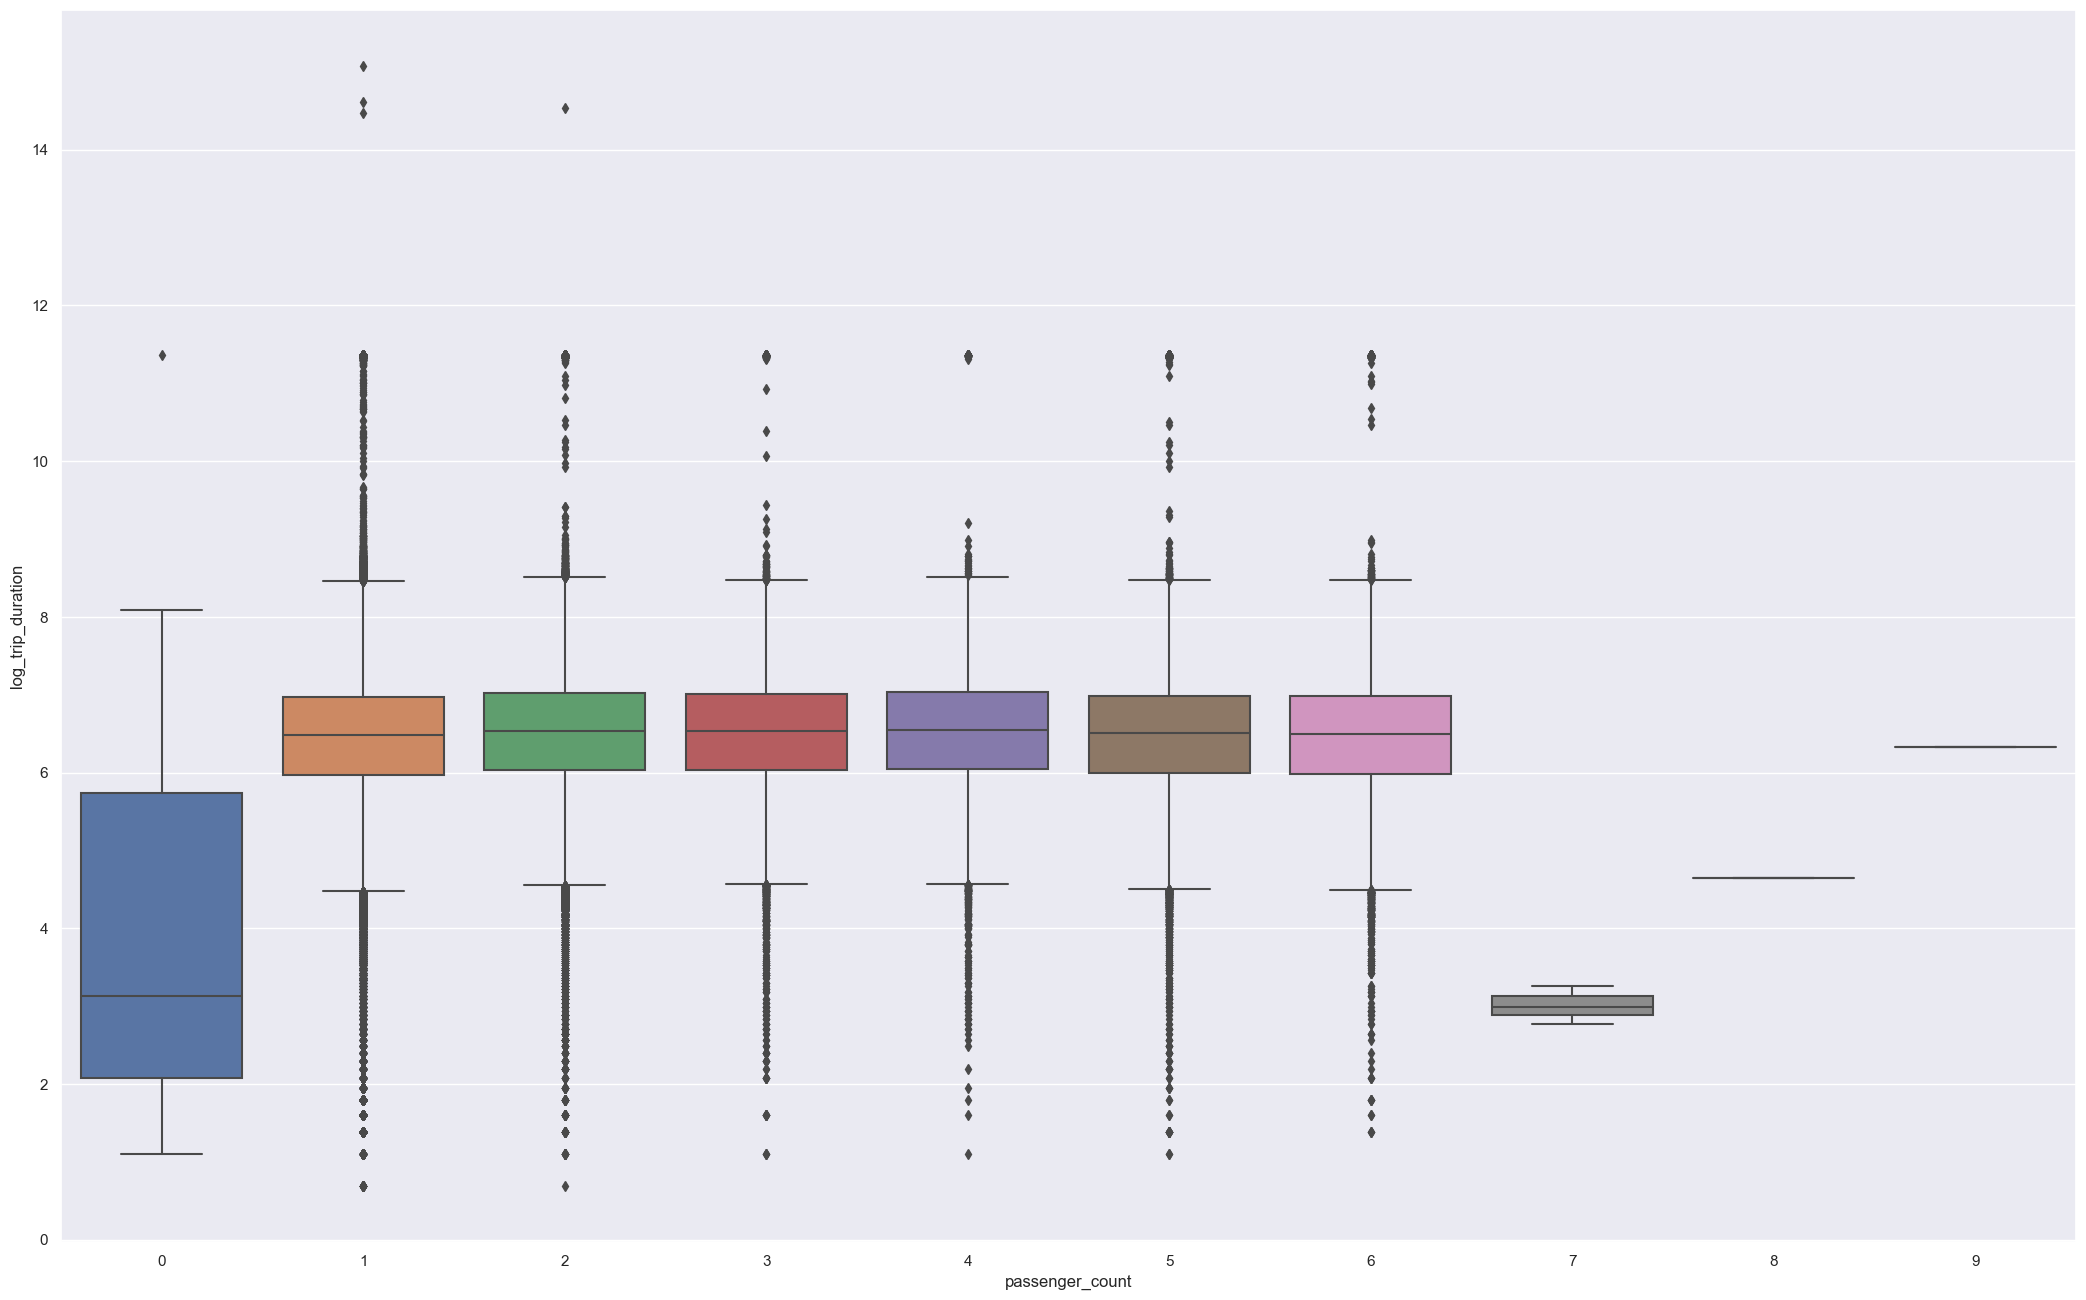

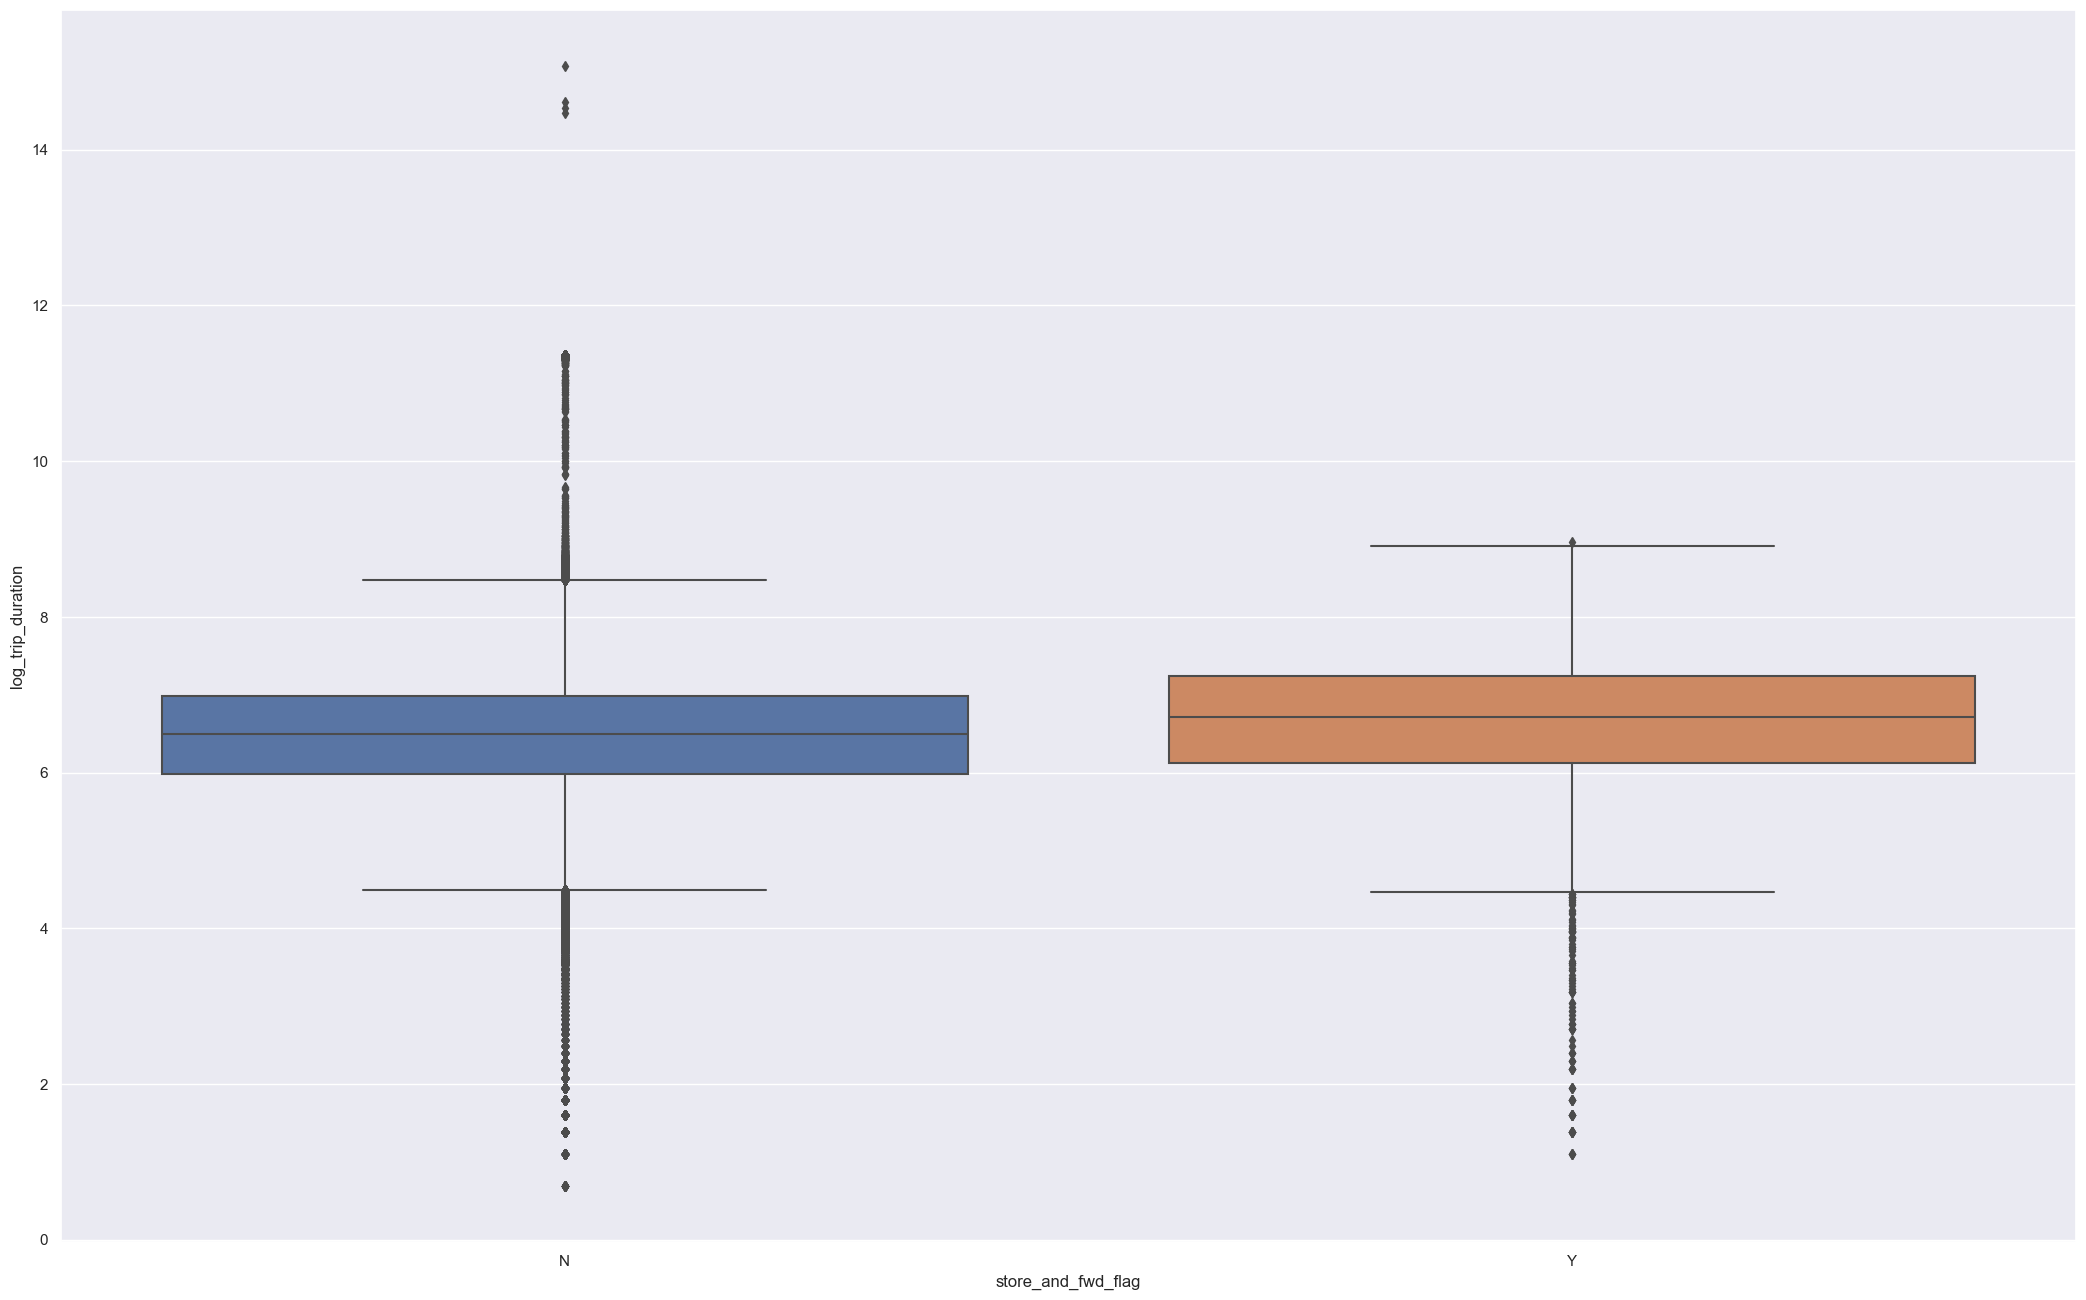

In [37]:

for feature in ['vendor_id', 'passenger_count', 'store_and_fwd_flag']:
    sns.boxplot(x=feature, y='log_trip_duration', data=df_train)
    plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [38]:
#Это сделает за меня one hot encoder, я лучше удалю выбросы, которые детектятся с помощью passnger_count

def remove_dropout_passenger_count(df_with_dropout):
    return df_with_dropout[df_with_dropout['passenger_count'].isin([1,2,3,4,5,6])]

df_train = remove_dropout_passenger_count(df_train)
df_test = remove_dropout_passenger_count(df_test)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель, в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [39]:
features_to_exclude = ['id', 'pickup_datetime', 'dropoff_latitude', 'dropoff_longitude', 'pickup_latitude',
                       'pickup_longitude', "day_of_year", 'store_and_fwd_flag', 'vendor_id', 'passenger_count']

y_train = df_train["log_trip_duration"]
X_train = df_train.drop(columns=features_to_exclude + ["log_trip_duration"])
y_test = df_test["log_trip_duration"]
X_test = df_test.drop(columns=features_to_exclude + ["log_trip_duration"])

preprocessor_task_12 = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['log_haversine']),
        ('ohe', OneHotEncoder(), ['day_of_week', 'hour', 'month', 'pickup_cell', 'dropoff_cell'])],
    remainder='passthrough',
)

Ridge_model_task_12 = Pipeline(steps=[('preprocessor', preprocessor_task_12),
                                      ('regression_ridge', Ridge())])

Ridge_model_task_12.fit(X_train, y_train)

print("R2 score:", Ridge_model_task_12.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, Ridge_model_task_12.predict(X_test)))

R2 score: 0.6164591962998758
MSE: 0.24269522012153236


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

Axes(0.125,0.11;0.775x0.77)


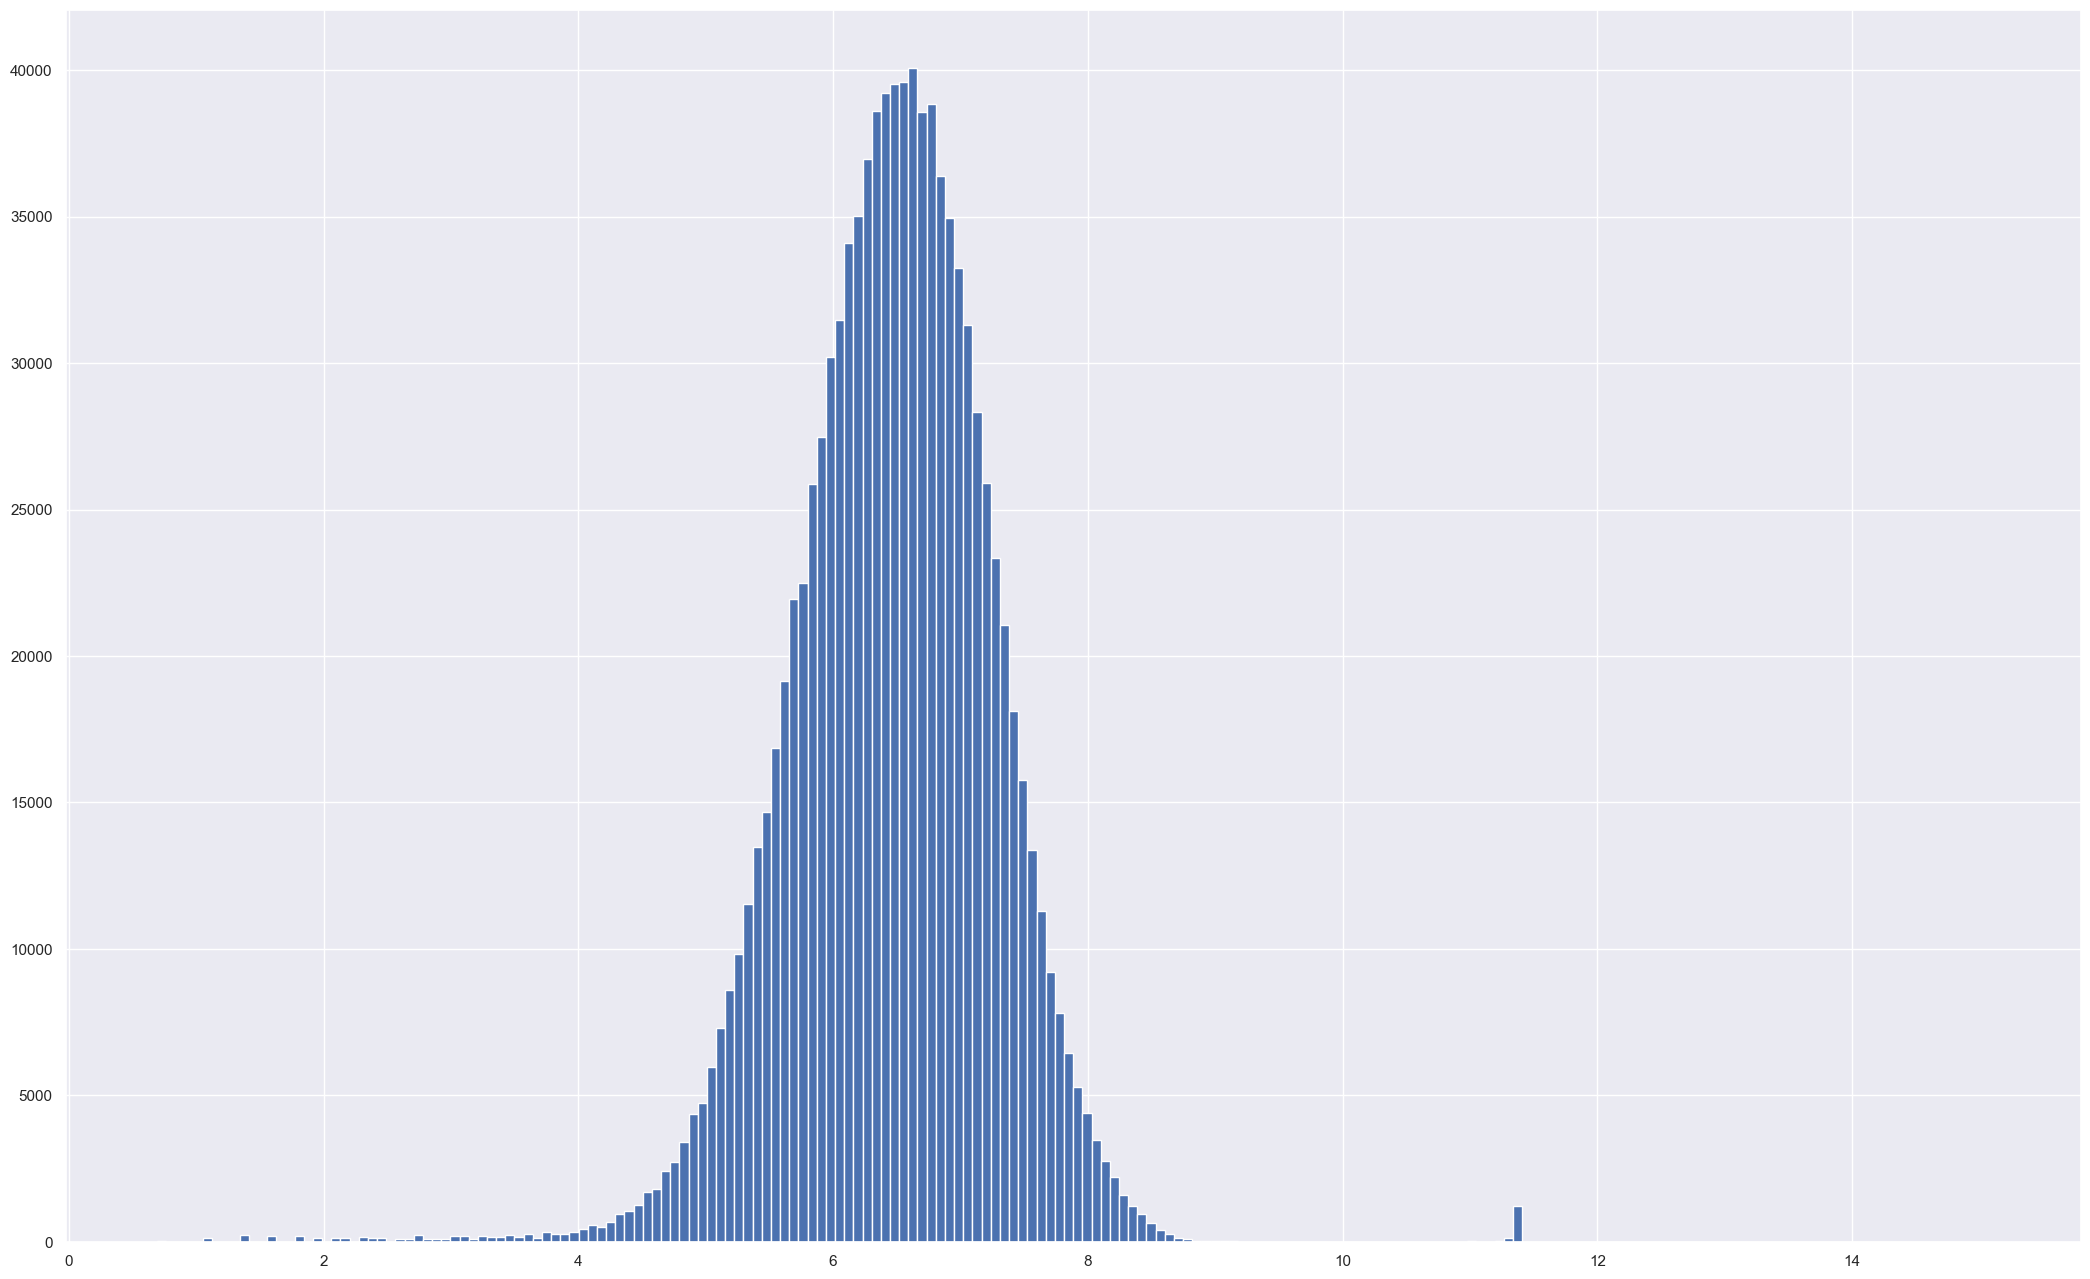

In [40]:
print(df_train['log_trip_duration'].hist(bins=200))

In [41]:
df_train['log_trip_duration'].quantile(0.0028)

3.2188758248682006

In [42]:
def remove_dropout(dff):
    upper_quantile = dff['log_trip_duration'].quantile(0.9985)
    lower_quantile = dff['log_trip_duration'].quantile(0.003)
    return dff[dff['log_trip_duration'].between(lower_quantile, upper_quantile)]



Axes(0.125,0.11;0.775x0.77)


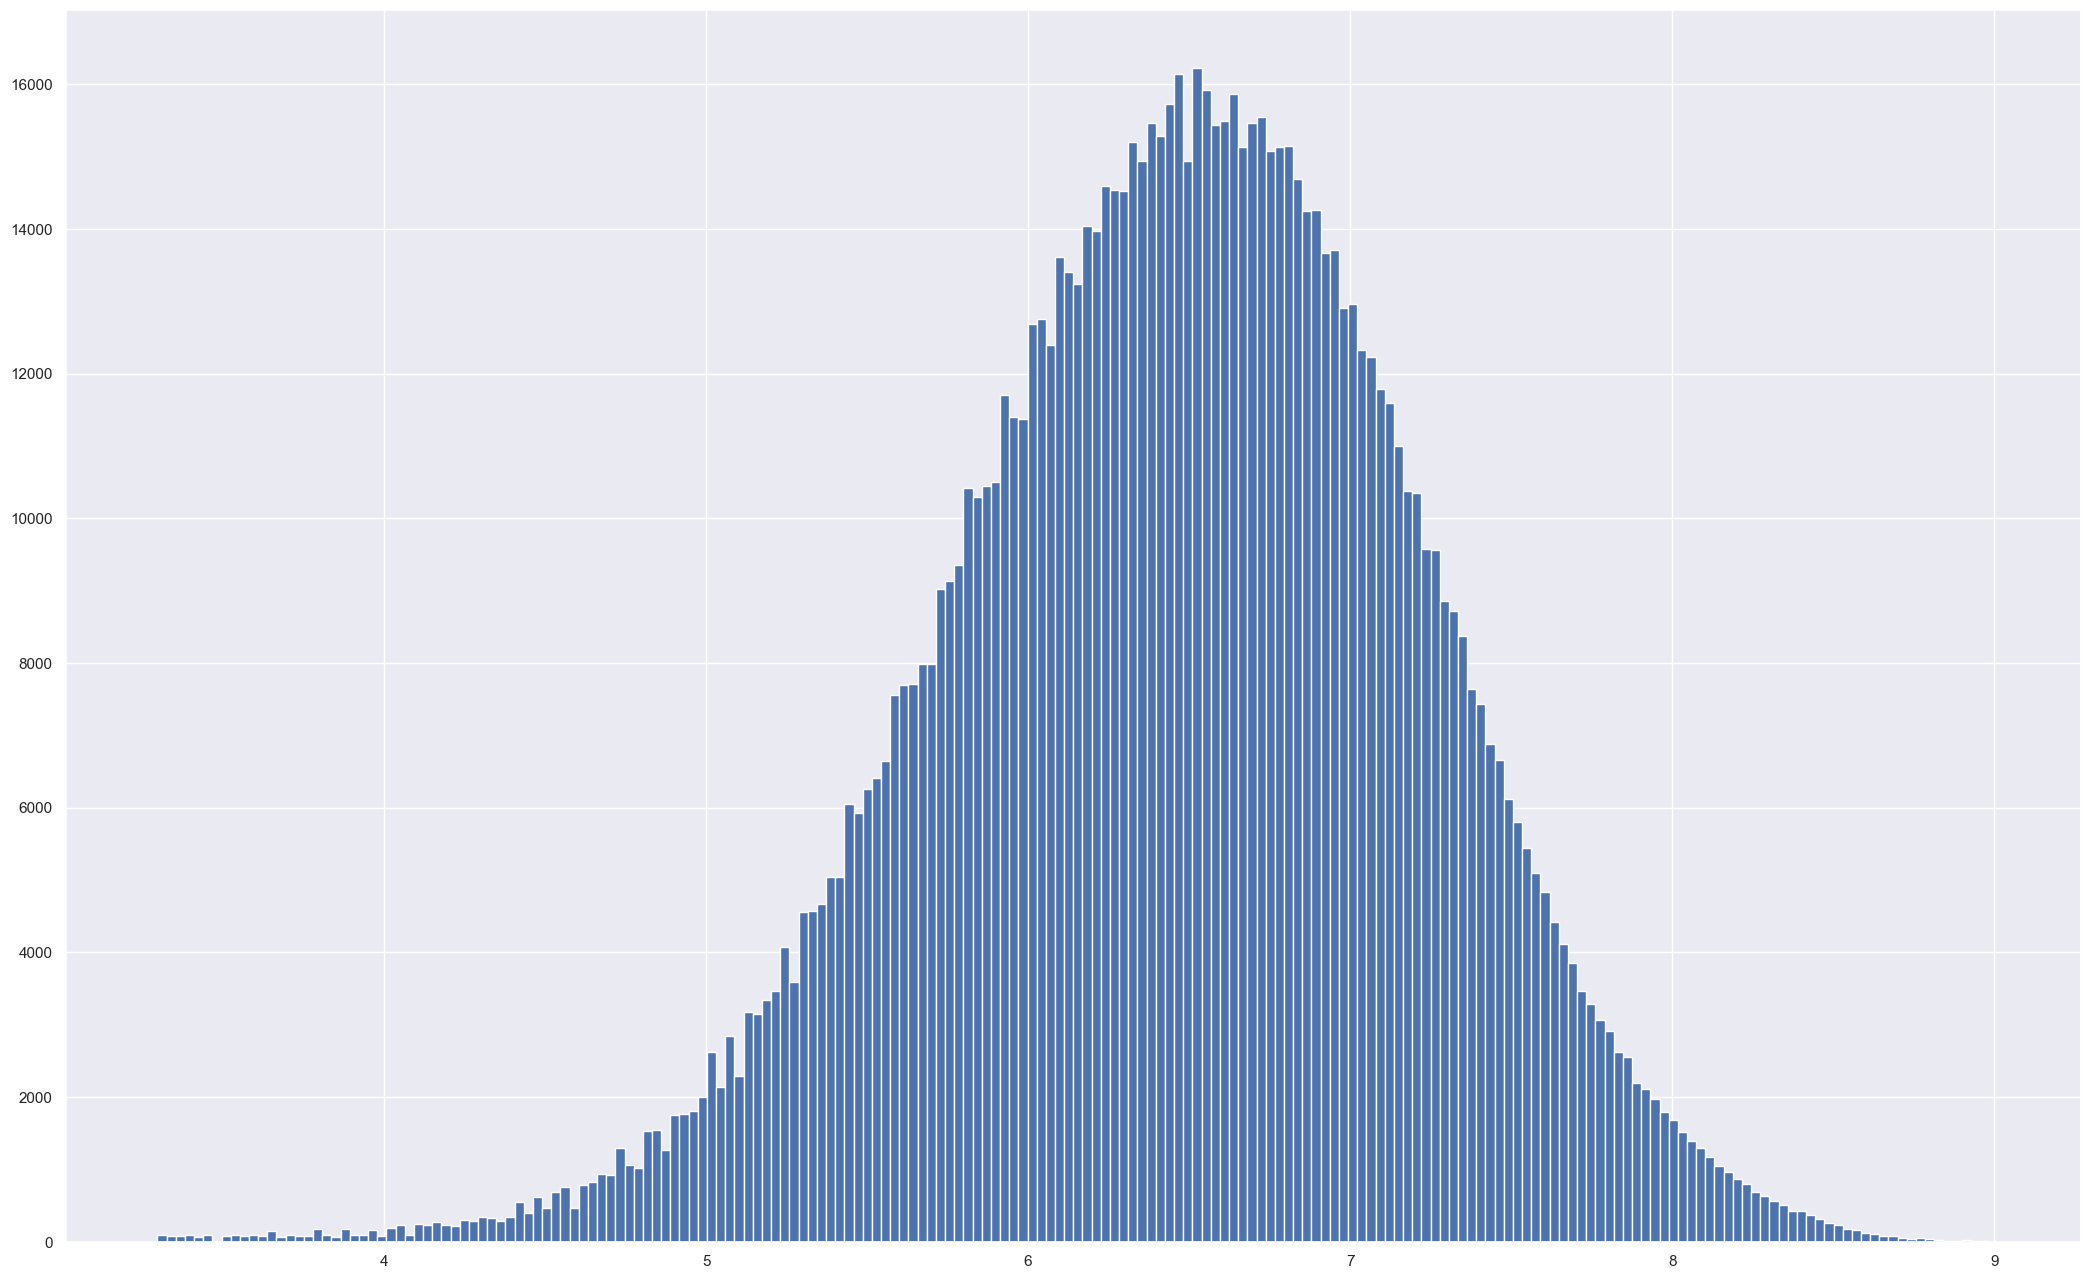

In [43]:
print(remove_dropout(df_train)['log_trip_duration'].hist(bins=200))

In [44]:
df_train = remove_dropout(df_train)
df_test = remove_dropout(df_test)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [45]:
df_train.in_traffic.value_counts()

1    679246
0    337253
Name: in_traffic, dtype: int64

In [46]:
binary_rare_features = ['bigger_anomaly', 'smaller_anomaly', 'in_traffic', 'newark_start', 'newark_end', 'jfk_start', 'jfk_end']

for col in binary_rare_features:
    counts = df_train[col].value_counts()
    true_count = counts.loc[1]  # количество
    total_count = counts.sum()  # общее количество значений в столбце
    rare_ratio = true_count / total_count  # доля редких значений
    print(f"Feature {col}: {rare_ratio:.2%} of all rows is True")

Feature bigger_anomaly: 0.75% of all rows is True
Feature smaller_anomaly: 1.78% of all rows is True
Feature in_traffic: 66.82% of all rows is True
Feature newark_start: 0.00% of all rows is True
Feature newark_end: 0.00% of all rows is True
Feature jfk_start: 2.12% of all rows is True
Feature jfk_end: 0.89% of all rows is True


In [47]:
def unite_rare_binary_features(dff):
    dff['feature_that_makes_trip_longer']=0
    mask = (dff['bigger_anomaly']==1) | (dff['smaller_anomaly']==1) | (dff['newark_start']==1) | (dff['newark_end']==1) | (dff['jfk_start']==1) | (dff['jfk_end']==1)
    dff.loc[mask, 'feature_that_makes_trip_longer'] = 1
    dff = dff.drop(columns=['bigger_anomaly', 'smaller_anomaly', 'newark_start', 'newark_end', 'jfk_start', 'jfk_end'], axis=1)
    return dff

df_train = unite_rare_binary_features(df_train)
df_test = unite_rare_binary_features(df_test)

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**.Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [48]:
from sklearn.linear_model import Lasso

features_to_exclude = ['id', 'pickup_datetime', 'dropoff_latitude', 'dropoff_longitude', 'pickup_latitude',
                       'pickup_longitude',  'vendor_id', 'passenger_count']

y_train = df_train["log_trip_duration"]
X_train = df_train.drop(columns=features_to_exclude + ["log_trip_duration"])
y_test = df_test["log_trip_duration"]
X_test = df_test.drop(columns=features_to_exclude + ["log_trip_duration"])

preprocessor_task_14 = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['log_haversine', 'day_of_year']),
        ('ohe', OneHotEncoder(), ['day_of_week', 'hour', 'month', 'pickup_cell', 'dropoff_cell', 'store_and_fwd_flag'])],
    remainder='passthrough',
)

Lasso_model_task_14 = Pipeline(steps=[('preprocessor', preprocessor_task_14),
                                      ('lasso', Lasso())])

Lasso_model_task_14.fit(X_train, y_train)


print("Lasso R2 score:", Lasso_model_task_14.score(X_test, y_test))
print("Lasso MSE:", mean_squared_error(y_test, Lasso_model_task_14.predict(X_test)))


Lasso R2 score: -1.052601653173113e-06
Lasso MSE: 0.5498200257105684


In [49]:

Ridge_model_task_14 = Pipeline(steps=[('preprocessor', preprocessor_task_14),
                                      ('ridge', Ridge())])

Ridge_model_task_14.fit(X_train, y_train)
print("Ridge R2 score:", Ridge_model_task_14.score(X_test, y_test))
print("Ridge MSE:", mean_squared_error(y_test, Ridge_model_task_14.predict(X_test)))

Ridge R2 score: 0.6563569657520039
Ridge MSE: 0.18894162304522627


## Ridge показывает значительно лучшие результаты после того, как я объединил редкие бинарные признаки в один. Очень приятно на душе.

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [50]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_valid, y_train, y_valid = train_test_split(df_train.drop(columns=['log_trip_duration']), df_train['log_trip_duration'], test_size=0.2, random_state=33)
X_train = X_train.drop(columns=features_to_exclude)
X_valid = X_valid.drop(columns=features_to_exclude)

grid_search_ridge = GridSearchCV(Ridge_model_task_14, param_grid={'ridge__alpha': np.logspace(-5, 3, 10)})
grid_search_ridge.fit(X_valid, y_valid)
best_alpha_ridge = grid_search_ridge.best_params_['ridge__alpha']
print("Best alpha Ridge:", best_alpha_ridge)

grid_search_lasso = GridSearchCV(Lasso_model_task_14, param_grid={'lasso__alpha': np.logspace(-5, 3, 10)})
grid_search_lasso.fit(X_valid, y_valid)
best_alpha_lasso = grid_search_lasso.best_params_['lasso__alpha']
print("Best alpha Lasso:", best_alpha_lasso)

Best alpha Ridge: 0.004641588833612777
Best alpha Lasso: 1e-05


In [51]:

ridge_model_best_alpha = Pipeline(steps=[('preprocessor', preprocessor_task_14),
                                      ('ridge', Ridge(alpha=best_alpha_ridge))])
ridge_model_best_alpha.fit(X_train, y_train)
print("Ridge R2 score:", ridge_model_best_alpha.score(X_test, y_test))
print("Ridge MSE:", mean_squared_error(y_test, ridge_model_best_alpha.predict(X_test)))


lasso_model_best_alpha = Pipeline(steps=[('preprocessor', preprocessor_task_14),
                                      ('ridge', Lasso(alpha=best_alpha_lasso))])
lasso_model_best_alpha.fit(X_train, y_train)
print("Lasso R2 score:", lasso_model_best_alpha.score(X_test, y_test))
print("Lasso MSE:", mean_squared_error(y_test, lasso_model_best_alpha.predict(X_test)))

Ridge R2 score: 0.6563560655384229
Ridge MSE: 0.18894211800015953
Lasso R2 score: 0.6563538918085086
Lasso MSE: 0.18894331315913887


In [52]:
gc.collect()

31170

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [53]:
grid_search_lasso.cv_results_

{'mean_fit_time': array([8.58115568, 1.17988667, 0.60606642, 0.28527336, 0.20885844,
        0.18841085, 0.18194981, 0.18262882, 0.20058379, 0.18630896]),
 'std_fit_time': array([1.83289976, 0.17139529, 0.02382439, 0.00629401, 0.00483904,
        0.00429445, 0.00858715, 0.00825441, 0.01629862, 0.00384301]),
 'mean_score_time': array([0.02752557, 0.02712607, 0.02753787, 0.02735653, 0.02653518,
        0.02715383, 0.02533288, 0.0282383 , 0.02764654, 0.02819133]),
 'std_score_time': array([0.00444334, 0.00284783, 0.00303421, 0.00196397, 0.0010086 ,
        0.00362461, 0.00102675, 0.00308914, 0.00087755, 0.00342632]),
 'param_lasso__alpha': masked_array(data=[1e-05, 7.742636826811278e-05, 0.0005994842503189409,
                    0.004641588833612777, 0.03593813663804626,
                    0.2782559402207126, 2.154434690031882,
                    16.681005372000556, 129.15496650148827, 1000.0],
              mask=[False, False, False, False, False, False, False, False,
                

(-0.6, 3.0)

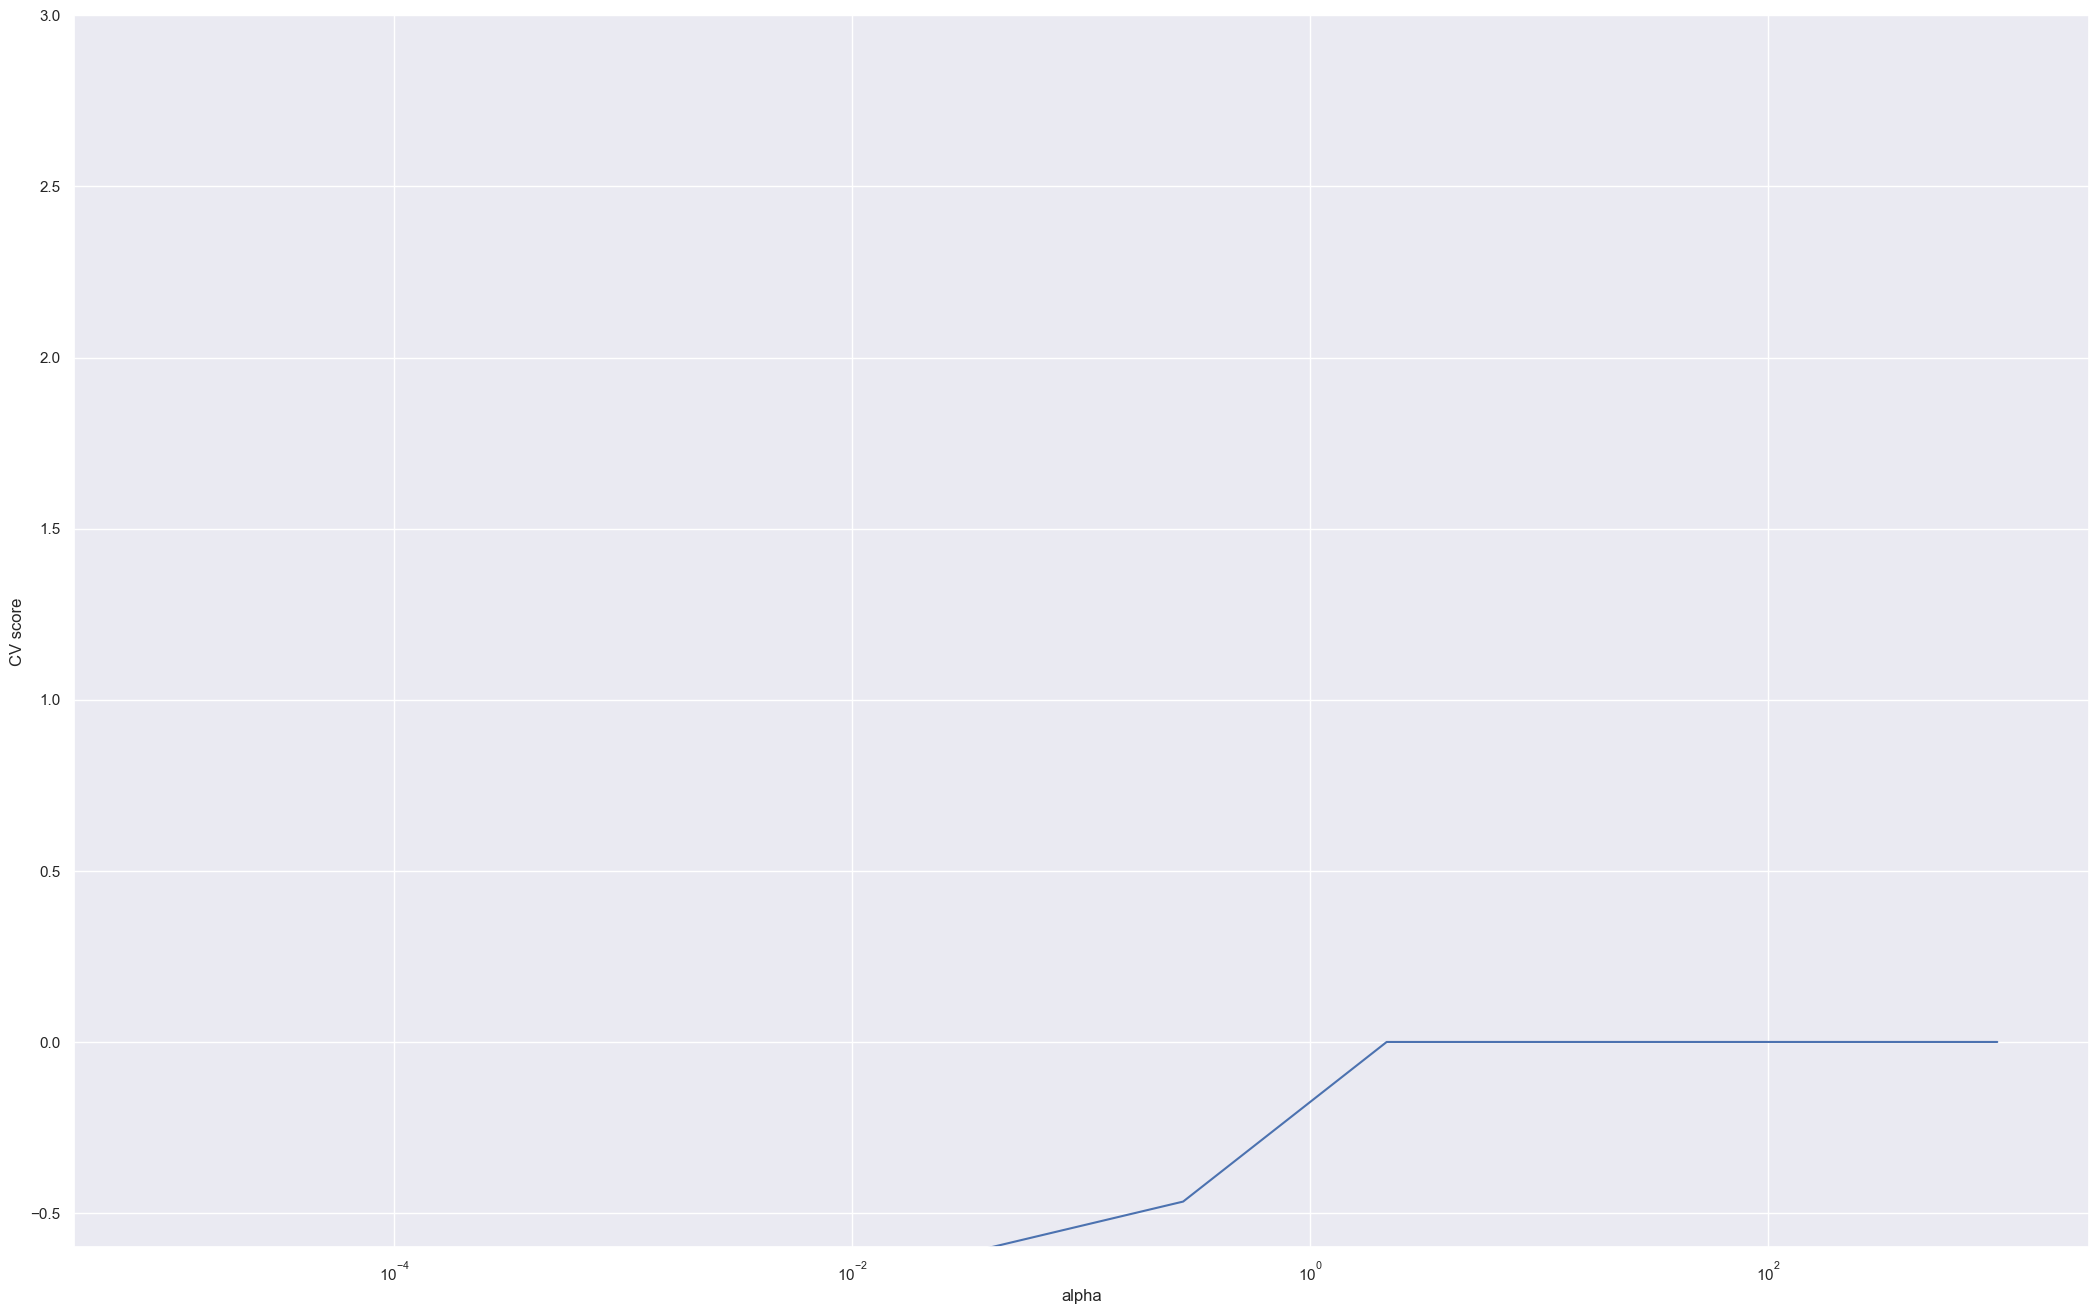

In [54]:
# извлекаем данные из cv_results_
plt.plot(np.logspace(-5, 3, 10), -grid_search_lasso.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.ylim(-0.6, 3)

## Теперь обучим нашу модель, основываясь на всём train dataset, а затем попробуем предсказать результаты для text.csv и загрузить предсказания на kaggle

In [55]:
df = pd.concat([df_train, df_test])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452102 entries, 0 to 1458643
Data columns (total 19 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   id                              1452102 non-null  object        
 1   vendor_id                       1452102 non-null  int64         
 2   pickup_datetime                 1452102 non-null  datetime64[ns]
 3   passenger_count                 1452102 non-null  int64         
 4   pickup_longitude                1452102 non-null  float64       
 5   pickup_latitude                 1452102 non-null  float64       
 6   dropoff_longitude               1452102 non-null  float64       
 7   dropoff_latitude                1452102 non-null  float64       
 8   store_and_fwd_flag              1452102 non-null  object        
 9   log_trip_duration               1452102 non-null  float64       
 10  hour                            1452102 no

Загрузим и преобразуем данные из test.csv

In [108]:
df_test = pd.read_csv('test.csv')
df_test['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df_test = df_test.fillna(df_test.pickup_datetime.mean())

df_test = make_time_features(df_test)
df_test = make_log_haversine_feature(df_test)
df_test = make_anomaly_features(df_test)
df_test = make_airport_features(df_test)
df_test = make_traffic_features(df_test)
df_test = transformer.transform(df_test)
df_test = unite_rare_binary_features(df_test)

df_test = df_test.reindex(columns=df.columns)
df_test.drop(columns=['log_trip_duration'], axis=1, inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              625134 non-null  object        
 1   vendor_id                       625134 non-null  int64         
 2   pickup_datetime                 625134 non-null  datetime64[ns]
 3   passenger_count                 625134 non-null  int64         
 4   pickup_longitude                625134 non-null  float64       
 5   pickup_latitude                 625134 non-null  float64       
 6   dropoff_longitude               625134 non-null  float64       
 7   dropoff_latitude                625134 non-null  float64       
 8   store_and_fwd_flag              625134 non-null  object        
 9   hour                            625134 non-null  int64         
 10  month                           625134 non-null  int64  

In [109]:
features_to_exclude = ['id', 'pickup_datetime', 'dropoff_latitude', 'dropoff_longitude', 'pickup_latitude',
                       'pickup_longitude',  'vendor_id', 'passenger_count']

X_test = df_test.drop(columns=features_to_exclude)


y_train = df["log_trip_duration"]
X_train = df.drop(columns=features_to_exclude + ["log_trip_duration"])

ridge_model_best_alpha = Pipeline(steps=[('preprocessor', preprocessor_task_14),
                                      ('ridge', Ridge(alpha=best_alpha_ridge))])
ridge_model_best_alpha.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['log_haversine',
                                                   'day_of_year']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['day_of_week', 'hour',
                                                   'month', 'pickup_cell',
                                                   'dropoff_cell',
                                                   'store_and_fwd_flag'])])),
                ('ridge', Ridge(alpha=0.004641588833612777))])

In [110]:
log_ridge_predicts=ridge_model_best_alpha.predict(X_test)


In [111]:
ridge_predicts = np.exp(log_ridge_predicts)


# создаем DataFrame с прогнозами
submission = pd.DataFrame({'id': df_test['id'], 'trip_duration': ridge_predicts})

# сохраняем DataFrame в csv
submission.to_csv('submission.csv', index=False)
